In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt

import time, datetime, socket

import tfdiffeq
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

# tf.config.list_physical_devices('GPU')

device = 'cpu:0' 

print(f"author  {socket.gethostname():>28}")
print(f"version {str(datetime.datetime.now()):>28}")
print(f"device  {device:>28}")

author                           NOB
version   2023-06-16 04:08:11.377395
device                         cpu:0


#### load tclab measured data  

model 4.6 consists of 12 cycles and a 360s period of time  
switch with 20s delay, followed by 100s up and 240s down

In [2]:
name = "model.4.6"
fname = os.path.join(os.getcwd(),"data","tclab.%s.csv"%(name))

from _helpers import Helpers_

t,u,y,data_size = Helpers_.tfload_(fname)

print(f"data {name:>10}")
print(f"size {data_size:>10}")

data  model.4.6
size       4320


#### import (neuronal) ode model and helper

In [3]:
from _models import NeuralODE, HelperODE

#### neural ode training by batch

monitoring data results and loss per iteration with optimizer adam  
batch decision to get a calm loss behaviour

In [20]:
%%time

c_up,c_down = "\u23f6","\u23f7"

# iterations to train
n_iters = 1000       

batch_time = 10     # time scale to odeint
batch_due = 0       # due to reduce data size 
                    # to a batch size
                    
batch_size = int((data_size-batch_due)/batch_time)

print_freq = 10     # freq to print sth out

print(f"iterations {n_iters}")
print(f"batch time {batch_time}, due {batch_due}, size {batch_size}")

data_monitor = []
loss_monitor = []

with tf.device(device):

    # build model
    model = NeuralODE()

    lr = 1e-3
    optimizer = tf.keras.optimizers.Adam(lr)

    itime = time.time()        

    # iterate
    print(f"iter | {'delay':>10} | {'loss':>15}")

    for itr in range(1,n_iters+1):
        
        with tf.GradientTape() as tape:

            # batch
            batch_y0, batch_t, _, batch_y, batch_i = HelperODE.batch_(
                t, None, y, 
                batch_size=batch_size, 
                batch_time=batch_time, 
                data_size=data_size)

            # integrate to predict
            y_pred = tfdiffeq.odeint(model, batch_y0, batch_t, method="dopri5") 

            # compute loss
            loss = tf.reduce_mean(tf.square(batch_y - y_pred))

            data_monitor.append([batch_i,y_pred.numpy().flatten()])
            loss_monitor.append([loss.numpy()])
        
        # pack loss and trainable variables of the tf model
        gg = tape.gradient(loss, model.trainable_variables)
        gv = zip(gg, model.trainable_variables)       
        
        # optimzer setup to do sth against the loss
        optimizer.apply_gradients(gv) 

        if itr % print_freq == 0:            
            dt = f"{time.time()-itime:5.2f}"
            ls = f"{loss.numpy():12.6f}"
            dr = c_down if loss.numpy() < loss_monitor[itr-print_freq][0] else c_up
            print(f"{itr:04d} | {dt:>10} | {ls:>15}{dr}")
            itime = time.time()


iterations 1000
batch time 10, due 0, size 432
iter |      delay |            loss
0010 |       7.60 |     2455.573334⏷
0020 |       7.27 |     2201.492801⏷
0030 |       7.19 |     1969.810557⏷
0040 |       6.90 |     1755.751895⏷
0050 |       7.13 |     1547.121791⏷
0060 |       7.07 |     1347.863803⏷
0070 |       6.55 |     1167.470992⏷
0080 |       6.67 |      997.486187⏷
0090 |       6.74 |      847.497246⏷
0100 |       7.91 |      693.968733⏷
0110 |       6.77 |      563.582075⏷
0120 |       6.78 |      448.731719⏷
0130 |       6.81 |      333.869867⏷
0140 |       7.82 |      251.687679⏷
0150 |       6.76 |      197.781900⏷
0160 |       6.78 |      153.120215⏷
0170 |       6.69 |      127.534404⏷
0180 |       9.73 |       99.867299⏷
0190 |       6.57 |       74.989803⏷
0200 |       5.70 |       58.494804⏷
0210 |       7.10 |       36.808687⏷
0220 |       6.72 |       24.121223⏷
0230 |       6.31 |       15.327587⏷
0240 |       6.10 |        9.946939⏷
0250 |       5.84 |       10.

#### save the neural ode model

In [42]:
model_name = os.path.join(os.getcwd(),"data","tclab.%s.node.tf"%(name))
model.save(model_name, save_format="tf")

INFO:tensorflow:Assets written to: c:\Develop\vsc\tclab\data\tclab.model.4.6.node.tf\assets


In [61]:
import pandas as pd
monitor_path = os.path.join(os.getcwd(),"data","tclab.%s.node.mo"%(name))
if not os.path.exists(monitor_path): os.mkdir(monitor_path)

data_monitor_filename = os.path.join(monitor_path,"data.monitor.pickle")
pd.DataFrame(np.array(data_monitor,dtype=object), columns=['index','y_pred']).to_pickle(data_monitor_filename)

loss_monitor_filename = os.path.join(monitor_path,"loss.monitor.pickle")
pd.DataFrame(np.array(loss_monitor,dtype=object), columns=['loss']).to_pickle(loss_monitor_filename)

print(f"data monitor size {os.path.getsize(data_monitor_filename):>10}")
print(f"loss monitor size {os.path.getsize(loss_monitor_filename):>10}")

data monitor size   38076717
loss monitor size      19679


#### plot results over data set and loss

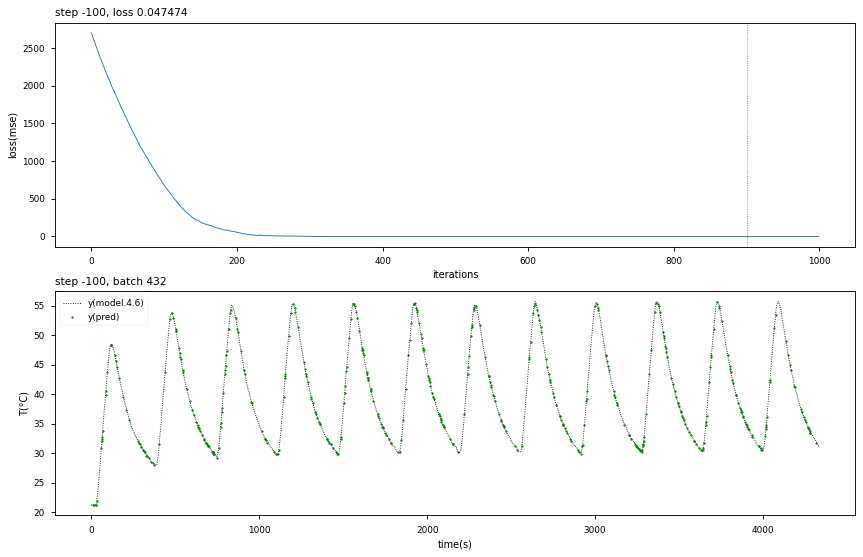

In [40]:
def plot_(data_monitor, loss_monitor, batch_size, step_number=-1):

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80
    plt.rcParams["lines.linewidth"] = .8

    ncols,nrows = 1,2
    nwidth,nheight = 16,4

    fig, axx = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nwidth*ncols,nheight*nrows],dpi=plt.rcParams["figure.dpi"])
    fig.subplots_adjust(right=0.75)

    ts = t.numpy().flatten()
    ys = y.numpy().flatten()

    k = step_number

    # ----------------------------

    ax = axx[1]
    ax.plot(ts,ys,":",color="black",label="y(%s)"%(name))

    # time by batched indizes
    i_ = data_monitor[k][0]
    t_ = ts[i_]

    # batch slices in one chain
    s_ = data_monitor[k][1]

    # plot last batch only
    i = 1
    y_ = s_[-i*batch_size:len(s_)-(i-1)*batch_size]
    ax.plot(t_,y_,'o',ms=2,label="y(pred)",color="green")

    ax.set_xlabel("time(s)"); ax.set_ylabel("T(°C)")

    ax.legend()
    ax.set_title(f"step {step_number}, batch {batch_size}",x=0,ha="left")

    # ----------------------------

    ax = axx[0]
    lm = np.array(loss_monitor).flatten()
    ax.plot(lm)

    ax.axvline(x=lm.shape[0]+step_number,color="grey",linestyle=":")

    ax.set_xlabel("iterations"); ax.set_ylabel("loss(mse)")
    ax.set_title(f"step {step_number}, loss {lm[-1]:.6f}",x=0,ha="left")

    plt.show()
    plt.close()

plot_(data_monitor, loss_monitor, batch_size, step_number=-100)

#### surrogate ode model and params  

with Q pickup by u_  
https://apmonitor.com/pdc/index.php/Main/ArduinoModeling

In [24]:
from _models import SurrogateODE, ParamsODE

#### compute neural ode (re-loaded) and surrogate ode over batch

In [25]:
%%time

batch_time_test = 2
batch_due_test = 0
batch_size_test = int((data_size-batch_due_test)/batch_time_test)

with tf.device(device):
    
    # reconstruct    
    recon = tf.keras.models.load_model(model_name,compile=False)
    
    batch_y0, batch_t, _, batch_y, batch_i = HelperODE.batch_(
        t, None, y, 
        batch_size=batch_size_test, 
        batch_time=batch_time_test, 
        data_size=data_size)
    
    y_test = tfdiffeq.odeint(recon, batch_y0, batch_t, method="dopri5")
    l_test = tf.reduce_mean(tf.square(batch_y - y_test))

    y_test = y_test.numpy().flatten() 

    # energy balance surrogate
    params = ParamsODE()
    balan = SurrogateODE(params=params)

    y_bala = tfdiffeq.odeint(balan, batch_y0, batch_t)
    l_bala = tf.reduce_mean(tf.square(batch_y - y_bala))
    y_bala = y_bala.numpy().flatten()

print(f"loss test {l_test:.6f} and surrogate {l_bala:.6f}")

loss test 0.039991 and surrogate 0.046215
CPU times: total: 344 ms
Wall time: 545 ms


#### plot surrogate and neural ode test results

the higher the batch due, the smaller the batch and the loss increases  
surrogate cannot make a better evaluation, if step of batches are to high  
for test purposes only that the model is reconstructed correctly and to compare the surrogate  

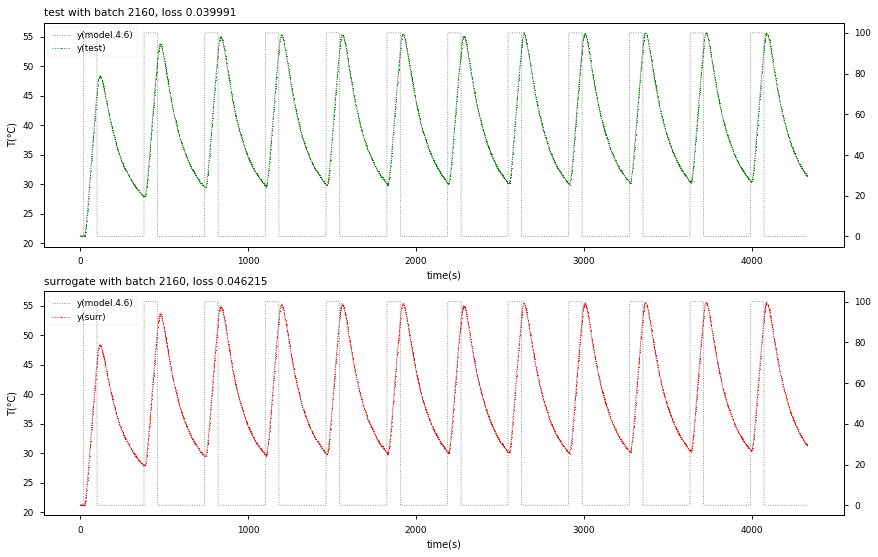

In [26]:

def plot_test(ts,us,ys,
              yy,
              loss,
              indizes,
              size,
              name
              ):

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80
    plt.rcParams["lines.linewidth"] = .8

    marker_size = 1

    ncols,nrows = 1,2
    nwidth,nheight = 16,4

    fig, axx = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nwidth*ncols,nheight*nrows],dpi=plt.rcParams["figure.dpi"])
    fig.subplots_adjust(right=0.75)

    # model test

    ax = axx[0]

    ax.plot(ts,ys,":",color="grey",label="y(%s)"%(name))

    i_ = indizes
    a_ = np.argsort(i_)
    t_ = ts[i_[a_]]
    y_ = yy[0][-size:][a_]

    ax.plot(t_,y_,':o',ms=marker_size,label="y(test)",color="green")

    ax.legend()
    ax.set_title("test with batch %d, loss %.6f"%(size, loss[0]),x=0,ha="left")

    ax = ax.twinx()
    ax.plot(ts,us,":",label="u",color="gray")

    # balance equivalence

    ax = axx[1]

    ax.plot(ts,ys,":",color="grey",label="y(%s)"%(name))

    i_ = indizes
    a_ = np.argsort(i_)
    t_ = ts[i_[a_]]
    y_ = yy[1][-size:][a_]

    ax.plot(t_,y_,':o',ms=marker_size,label="y(surr)",color="red")

    ax.legend()
    ax.set_title("surrogate with batch %d, loss %.6f"%(size,loss[1]),x=0,ha="left")

    ax = ax.twinx()
    ax.plot(ts,us,":",label="u",color="gray")

    for ax in axx.ravel():
        ax.set_xlabel("time(s)")
        ax.set_ylabel("T(°C)")

    plt.show()
    plt.close()

ts = t.numpy().flatten()
us = u.numpy().flatten()
ys = y.numpy().flatten()

plot_test(ts,us,ys,
          yy=[y_test,y_bala],
          loss=[l_test,l_bala],
          indizes=batch_i,
          size=batch_size_test,
          name=name
          )

#### load data of model.q.X  

test for convenience  
model contains random generated switching states

In [27]:
name2 = "model.q.3"
fname2 = os.path.join(os.getcwd(),"data","tclab.%s.csv"%(name2))

t2,u2,y2,data_size2 = Helpers_.tfload_(fname2)

print(f"load data '{name2}' with size {data_size2}")

load data 'model.q.3' with size 1200


In [36]:
%%time

batch_time_test2 = 2
batch_due_test2 = 0
batch_size_test2 = int((data_size2 - batch_due_test2)/batch_time_test2)

with tf.device(device):
    
    # reconstruct the trained neural ode
    model_name = os.path.join(os.getcwd(),"data","tclab.model.4.6.node.tf")
    recon = tf.keras.models.load_model(model_name, compile=False)
    
    batch_y02, batch_t2, _, batch_y2,batch_i2 = HelperODE.batch_(
        t2, None, y2, 
        batch_size=batch_size_test2, 
        batch_time=batch_time_test2, 
        data_size=data_size2)
    
    y_test2 = tfdiffeq.odeint(recon, batch_y02, batch_t2, method="dopri5")
    l_test2 = tf.reduce_mean(tf.square(batch_y2 - y_test2))
    y_test2 = y_test2.numpy().flatten() 

    # energy balance surrogate
    params = ParamsODE()
    params.alpha = 0.
    balan = SurrogateODE(params=params)

    y_bala2 = tfdiffeq.odeint(balan, batch_y02, batch_t2)
    l_bala2 = tf.reduce_mean(tf.square(batch_y2 - y_bala2))
    y_bala2 = y_bala2.numpy().flatten()

print(f"data size {data_size2}; batch time {batch_time_test2} due {batch_due_test2} size {batch_size_test2}")
print(f"loss test {l_test2:.6f} and surrogate {l_bala2:.6f}")

data size 1200; batch time 2 due 0 size 600
loss test 0.009132 and surrogate 0.011240
CPU times: total: 344 ms
Wall time: 502 ms


#### plot q-test model result and surrogate test result  

surrogate is not as good as expected  
neural ode knows more about the instrinsic properties  

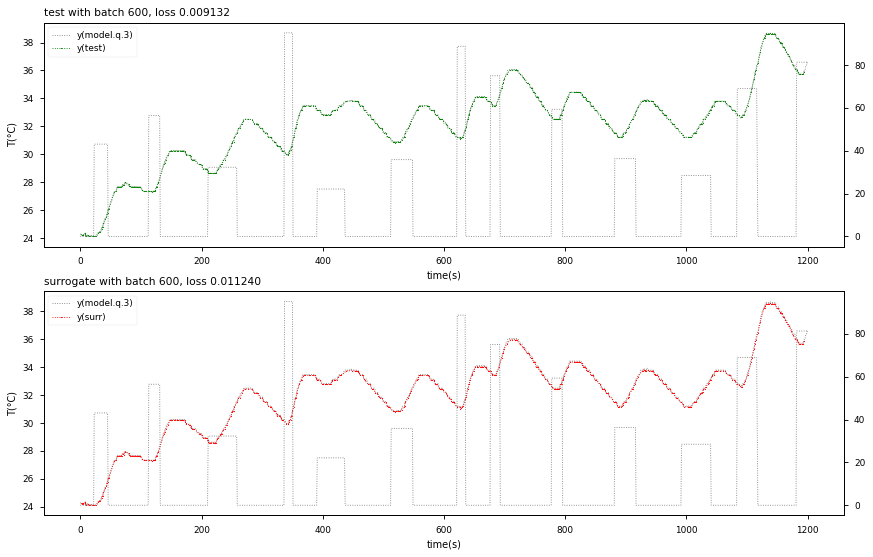

In [37]:
ts = t2.numpy().flatten()
us = u2.numpy().flatten()
ys = y2.numpy().flatten()


plot_test(ts,us,ys,
          yy=[y_test2,y_bala2],
          loss=[l_test2,l_bala2],
          indizes=batch_i2,
          size=batch_size_test2,
          name=name2
          )